!pip install pysynphot

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysynphot import spectrum as S
from glob import glob

import scipy
from scipy.optimize import minimize
from scipy.constants import k,c,h
from scipy import integrate

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb

# Definition

In [60]:
#Input wavelength: m

def blackbody(temp,lam):
    '''
    Planck's law[W/m**2/m/sr][W/m**2/Hz/sr]  
    [input]
    temp: star's effective temperature
    lam: wavelength[m]
    [return]
    B_lambda:the spectral radiance of a body for wavelength
    B_freq:the spectral radiance of a body for frequency
    '''
    #frequency
    nu = c/lam
    B_lambda = 2*h*c**2 / (lam**5 * (np.exp(h*c/ (lam*k*temp)) - 1))
    B_freq = 2*h*nu**3 / (c**3 * (np.exp(h*nu/(k*temp)) - 1))
    return B_lambda, B_freq

#[W/m**2]
def sb(temp):
    '''
    Stefan–Boltzmann law[W] 
    [input]
    temp: star's effective temperature
    '''
    rad = sigma_sb * temp**4
    return rad


#fixed temperature
T = 3000




#

B_lambda = lambda lam: (2*h*c**2) / (lam**5 * (np.exp(h*c/ (lam*k*T)) - 1))

B_freq = lambda nu: 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))

In [59]:
##calculate blackbody [W/m**2/m]
def _bb(lam):
    '''
    Planck's law[W/m**2/m/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    B_lambda = (2*h*(np.power(c,2)) )/ (np.power(lam,5) * (np.exp(h*c/ (lam*k*T)) - 1))
    
    return B_lambda

##calculate blackbody [W/m**2/Hz] - for calculating magnitude
def _bb_f(lam):
    '''
    Planck's law[W/m**2/Hz/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq

# The Sun

In [62]:
#erg/s/cm**2/Hz
np.exp(-(-26.77+48.6)/2.5)

0.0001613394544225239

In [4]:
#Literature

#T_sun = 5777K
print(' L_sun = {:.2e}\n'.format(const.L_sun))
F_total = sigma_sb * 5777**4
L_sb = F_total * 4 * np.pi * R_sun**2
print(' L_sun (from Stefan–Boltzmann law) = {:.2e}\n'.format(L_sb))

 L_sun = 3.83e+26 W

 L_sun (from Stefan–Boltzmann law) = 3.84e+26 W / K4



In [63]:
T=5700
f_sun, f_sun_err = integrate.quad(B_freq, c/(7.4e-7), c/(4.6e-7)) 
L_s_test = f_sun * np.pi**2 * 4.0 * R_sun**2
f_s_test = L_s_test /(4*np.pi*au**2)
print(f_sun)
print(L_s_test)
print(f_s_test)

6307794.3752964325
1.2052614638419066e+26 m2
428.5688314082689


Text(0, 0.5, 'Intensity[W/m2/Hz]')

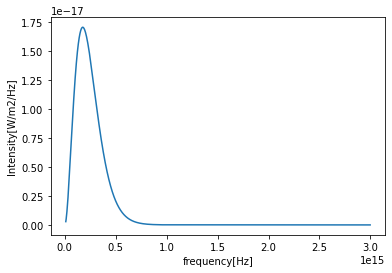

In [56]:
ar_lam = np.arange(1e-7, 3e-5, 1e-9)
ar_bb = np.empty(len(ar_lam))
for i in range(len(ar_lam)):
    ar_bb[i] = _bb_f(ar_lam[i])
    
plt.plot(c/ar_lam, ar_bb)
plt.xlabel('frequency[Hz]')
plt.ylabel('Intensity[W/m2/Hz]')

18633725.195909917
 L_sun_test = 3.56e+26 m2



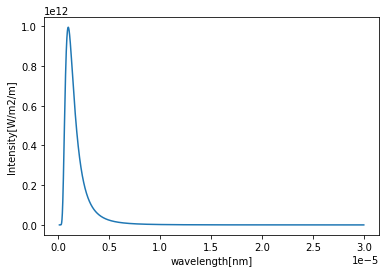

In [34]:
#test: calculate Luminosity of the Sun
#The blackbody radiation from the Sun: 100nm ~ 2500nm(3000nm)
ar_lam = np.arange(1e-7, 3e-5, 1e-9)
ar_bb = np.empty(len(ar_lam))
for i in range(len(ar_lam)):
    ar_bb[i] = _bb(ar_lam[i])
    
plt.plot(ar_lam, ar_bb)
plt.xlabel('wavelength[nm]')
plt.ylabel('Intensity[W/m2/m]')

T=5700
# Luminosity = F_total * surface area(4*pi*R_sun**2) = pi * integral(Blackbody,all wavelength) * surface area 
f_sun, f_sun_err = integrate.quad(B_lambda, 1e-7, 3e-6) 
L_s_test = f_sun * np.pi**2 * 4.0 * R_sun**2
print(f_sun)
print(' L_sun_test = {:.2e}\n'.format(L_s_test))

# Transmission

['./Generic_Johnson.B.dat', './Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat', './Kepler_Kepler.K.dat']


Text(0.5, 0, 'wavelength[m]')

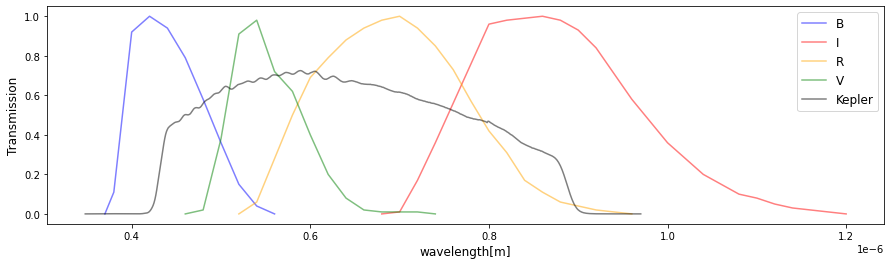

In [41]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

filt={}
bands = 'B,I,R,V,Kepler'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='b,r,orange,g,black'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,co in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*1e-10
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=co, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[m]',fontsize=12)

## Test: transmittance=100%

In [42]:
filt['V']

,0,1
0,4600.0,0.00
1,4800.0,0.02
2,5000.0,0.38
3,5200.0,0.91
4,5400.0,0.98
5,5600.0,0.72
6,5800.0,0.62
7,6000.0,0.40
8,6200.0,0.20
9,6400.0,0.08


In [21]:
T=3000
R_s=2*R_sun

flux_100 = []

for b in bands:
    df = filt[b]
    min_w = np.min(df[0])*1e-10
    max_w = np.max(df[0])*1e-10
    f_100,f_100err = integrate.quad(_bb,min_w,max_w) 
    flux_100.append(f_100)

In [22]:
flux_100

[37444.821711553144,
 483239.30172304047,
 335204.51769256167,
 142754.04928740064,
 368872.80898427893]

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

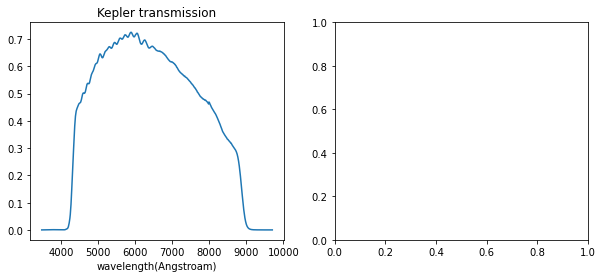

In [8]:
f,ax = plt.subplots(1, 2, figsize=(10,4))
b='Kepler'

ax[0].plot(filt[b][0], filt[b][1])
ax[0].set_xlabel('wavelength(Angstroam)')
ax[0].set_title('Kepler transmission')

array_lam = filt[b][0]*1e-9
array_bb_lam0 = np.empty(len(filt[b][0]))
array_bb_lam = np.empty(len(filt[b][0]))
array_bb_freq = np.empty(len(filt[b][0]))

temp=4000

for i in range(len(array_lam)):
    array_bb_lam0[i] = blackbody(temp,array_lam[i])[0]
    array_bb_lam[i] = blackbody(temp,array_lam[i])[0] * filt[b][1][i]
    array_bb_freq[i] = blackbody(temp,array_lam[i])[1] * filt[b][1][i]
    
ax[1].plot(array_lam, array_bb_lam0, label='bb')
ax[1].plot(array_lam, array_bb_lam, label='bb * transmission')
ax[1].legend(loc="upper left", fontsize=10)


f_obs_freq = sum(array_bb_freq) * ((2*R_sun)**2/(10*pc)**2)
f_obs_freq_abs = sum(array_bb_freq) * ((2*R_sun)**2/(10*pc)**2)
print(f_obs_freq)

#fluxunits: [erg/s/cm2/A]
plt.plot(S.Vega.wave, S.Vega.flux)
plt.xlim(0, 12000)
plt.xlabel(S.Vega.waveunits)
plt.ylabel(S.Vega.fluxunits)
plt.title(os.path.basename(S.Vega.name))

vega_kepler_flux = S.Vega.flux[(S.Vega.wave>3479.0) & (S.Vega.wave<9701.0)]
vega_kepler_wave =  S.Vega.wave[(S.Vega.wave>3479.0) & (S.Vega.wave<9701.0)]
plt.plot(vega_kepler_wave, vega_kepler_flux )